## Things that should only have to be defined once, here at the top
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from lmfit import Model, Parameters
from lmfit.models import VoigtModel

# from scipy.stats import chisquare
# from scipy.integrate import trapz, simpson
# from scipy.optimize import curve_fit
# from scipy.signal import savgol_filter

from astropy.io import fits

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458  # speed of light m/s

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x, ampl, center, std):
    return ((ampl) / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - center) / std) ** 2)) + 1

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA

# mask for test spectra to check out the nonsense with sigma and such
test_mask = standard_table['Name'].isin(['HBC427','Hubble4','LkCa14'])

standard_table = standard_table[test_mask].reset_index(drop=True)

# early_k = ('1', '2', '3', '4', '5')
# Only want to look at the K types for the moment
# standard_table_k = standard_table[standard_table['Spectral_Type'].str.startswith(('K1', 'K2', 'K5'))]

standard_shift = standard_table['Wavelength Shift'].values
standard_list = standard_table['Source'].values

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

hops_flux_length = max(len(fits.getdata(file)[1]) for file in hops_table['Source'])
hops_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_table['Source'])
hops_snr_length = max(len(fits.getdata(file)[2]) for file in hops_table['Source'])

# Initialize stacks with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)
raw_flux_err_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# hops_wavelen_stack = np.full((max_wavelen_length, len(hops_table)), np.nan)
# hops_raw_flux_stack = np.full((max_flux_length, len(hops_table)), np.nan)
# hops_snr_stack = np.full((max_snr_length, len(hops_table)), np.nan)
# hops_raw_flux_err_stack = np.full((max_snr_length, len(hops_table)), np.nan)


# Fill stacks with data
# Fill stacks with data
for i, file in enumerate(standard_list):
    # Get wavelength, flux, snr per resolution element data
    data = fits.getdata(file)
    wavelen, flux, snr = data[0], data[1], data[2]
    
    # Clean data a bit
    flux_min = 10000  # Minimum flux
    flux_cut = flux > flux_min  # Bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Calculate the error using raw_flux_err_stack
    flux_err = flux / snr
    
    # Now define the SNR cut using the raw_flux_err_stack
    snr_cut = (flux_err > 50)  # Example SNR cut

    # Apply masks and remove NaNs and infs
    mask = wavelen_cut & snr_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    flux_err = flux_err[mask]

    # Remove NaNs and infs from wavelen, flux, and flux_err arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isnan(flux) & ~np.isnan(flux_err)
    
    wavelen = wavelen[valid_indices]
    flux = flux[valid_indices]
    flux_err = flux_err[valid_indices]

    # Check for NaNs in the final arrays
    if np.any(np.isnan(wavelen)) or np.any(np.isnan(flux)) or np.any(np.isnan(flux_err)):
        print(f"NaNs found in data for file {file} after cleaning")

    # Update stacks with the cleaned data
    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux  # savgol_filter(flux, window_length=11, polyorder=3)
    raw_flux_err_stack[:len(flux_err), i] = flux_err

# fig = plt.figure(figsize=(15,5))
# plt.errorbar(wavelen_stack[:,1], raw_flux_stack[:,1], raw_flux_err_stack[:,1])
# plt.xlim(2.22,2.23)
# plt.ylim(3.8e5,5e5)
# plt.show()

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

## Ca Region

Ca I 2.2614

Fe I 2.2626 = lines_table[fe1_mask][29]

Ca I 2.2631

Ca I 2.2657



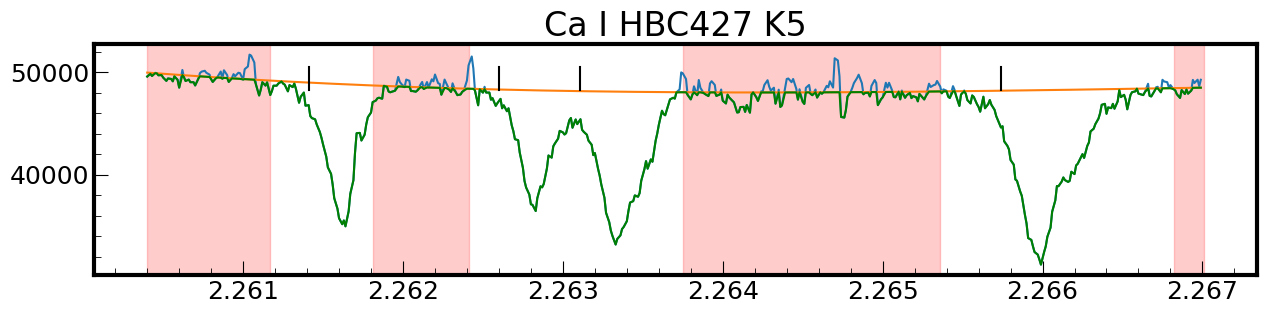

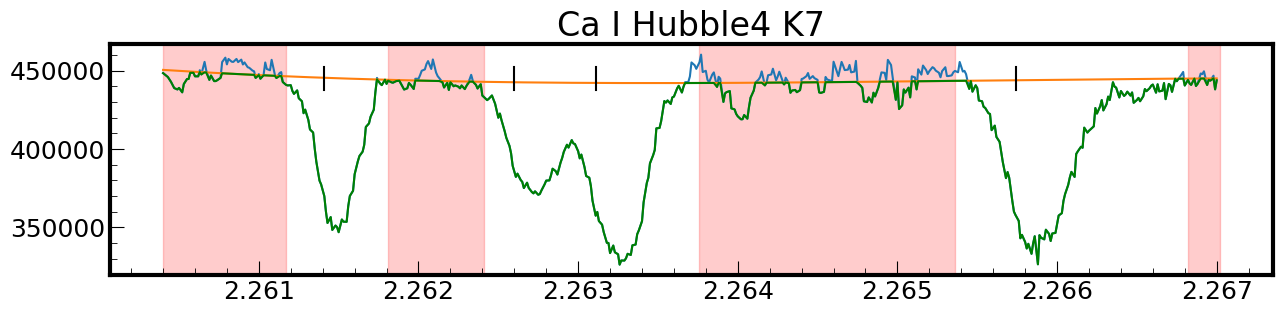

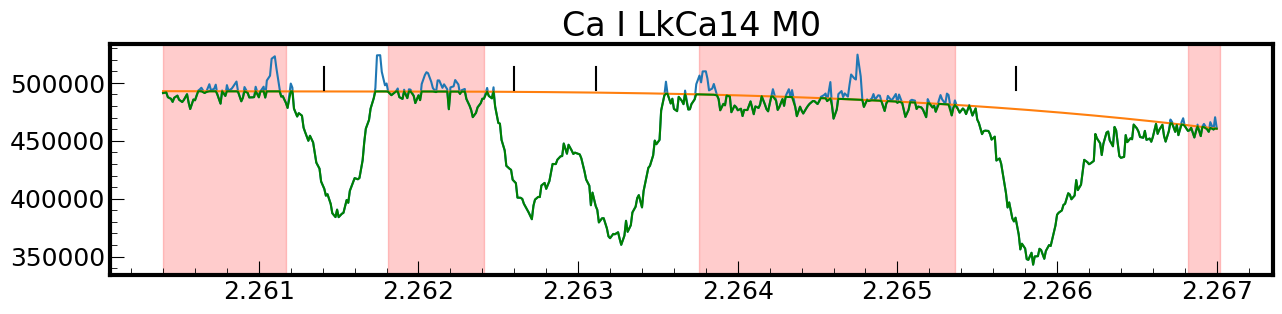

In [4]:
# Define the region for fitting
from sympy import Nor


line_name = lines_table[ca1_mask][0]['Spectrum'] # Species
line_center = lines_table[ca1_mask][0]['Observed'] # Wavelength

ca_reg_lines = list(lines_table[ca1_mask]['Observed'][:]) # list of Ca I lab wavelengths
ca_reg_lines.append(lines_table[fe1_mask]['Observed'][104])
ca_reg_lines = np.array(sorted(ca_reg_lines))

# from igrins_mod import local_continuum_fit
continuum_stack = []
continuum_err_stack = []
norm_flux_stack = []
norm_flux_err_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,75), (40,60), (235,160),(540,20)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table)):
    fig = plt.figure(figsize=(15,3))
    
    # Perform the continuum fit
    continuum, continuum_err, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                       raw_flux_stack[:,i],
                                                       raw_flux_err_stack[:,i],
                                                       poly_order = poly_deg,
                                                       line_center = line_center,
                                                       spec_res = spec_res,
                                                       regions = regions)
    # Append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # Append to list of the local continuum arrays
    continuum_stack.append(continuum)
    # continuum_err_stack.append(continuum_err)
    
    # Adjust flux values above the continuum
    adjusted_flux = np.minimum(raw_flux_stack[region_indices[0][0]:region_indices[n][1],i], continuum)
    
    # Normalize flux by dividing the adjusted flux by the continuum
    norm_flux = adjusted_flux / continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    # norm_flux_err = norm_flux[i] * np.sqrt( (raw_flux_err_stack[i]/raw_flux_stack[i])**2 + (continuum_err_stack[i]/continuum_stack[i])**2)
    # norm_flux_err_stack.append(norm_flux_err)
    
    # Plot the raw flux and continuum
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    
    # Plot the adjusted flux
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], adjusted_flux, linestyle='-', color='green')

    # Highlight the regions and Ca I lines
    for j in range(len(region_indices)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i], wavelen_stack[region_indices[n-j][1],i], color='red', alpha=.2)

    for k in range(len(ca_reg_lines)):
        plt.axvline(ca_reg_lines[k], ymin=0.8, ymax=0.9, color='black')
    
    plt.title(f"{line_name} {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    plt.show()

## Method 1

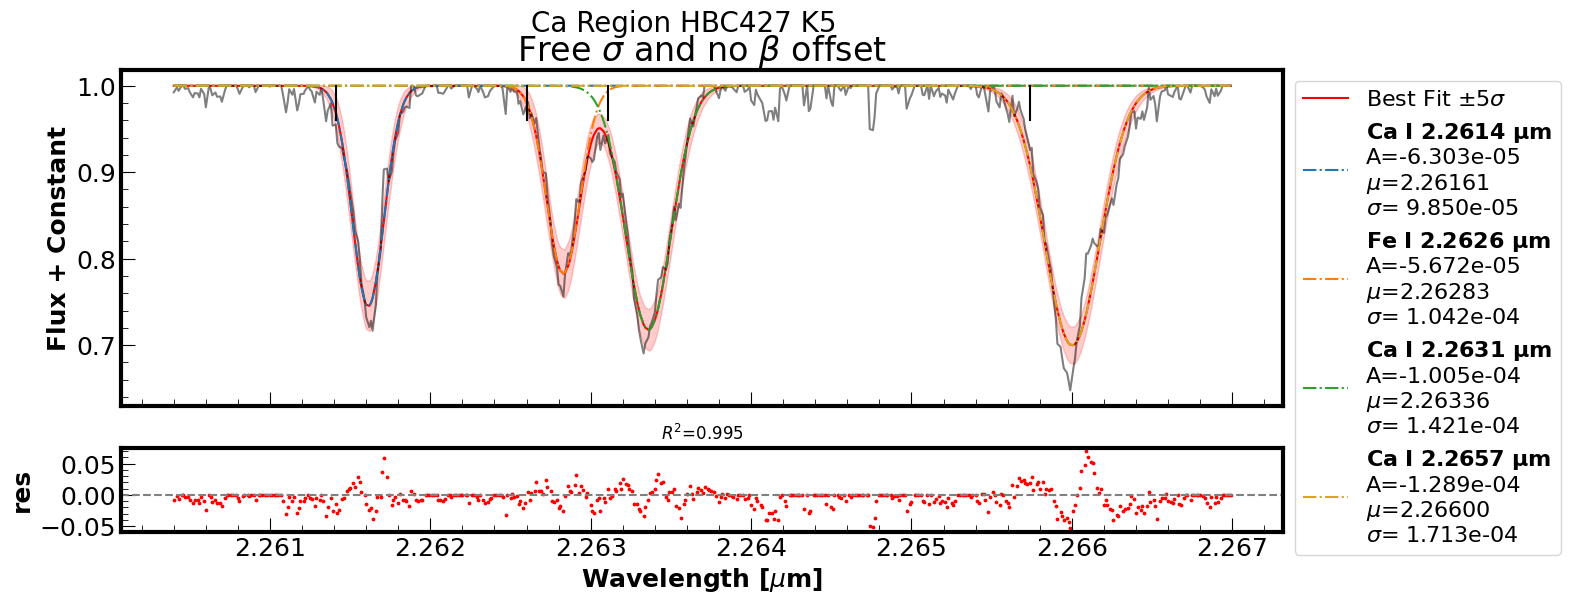

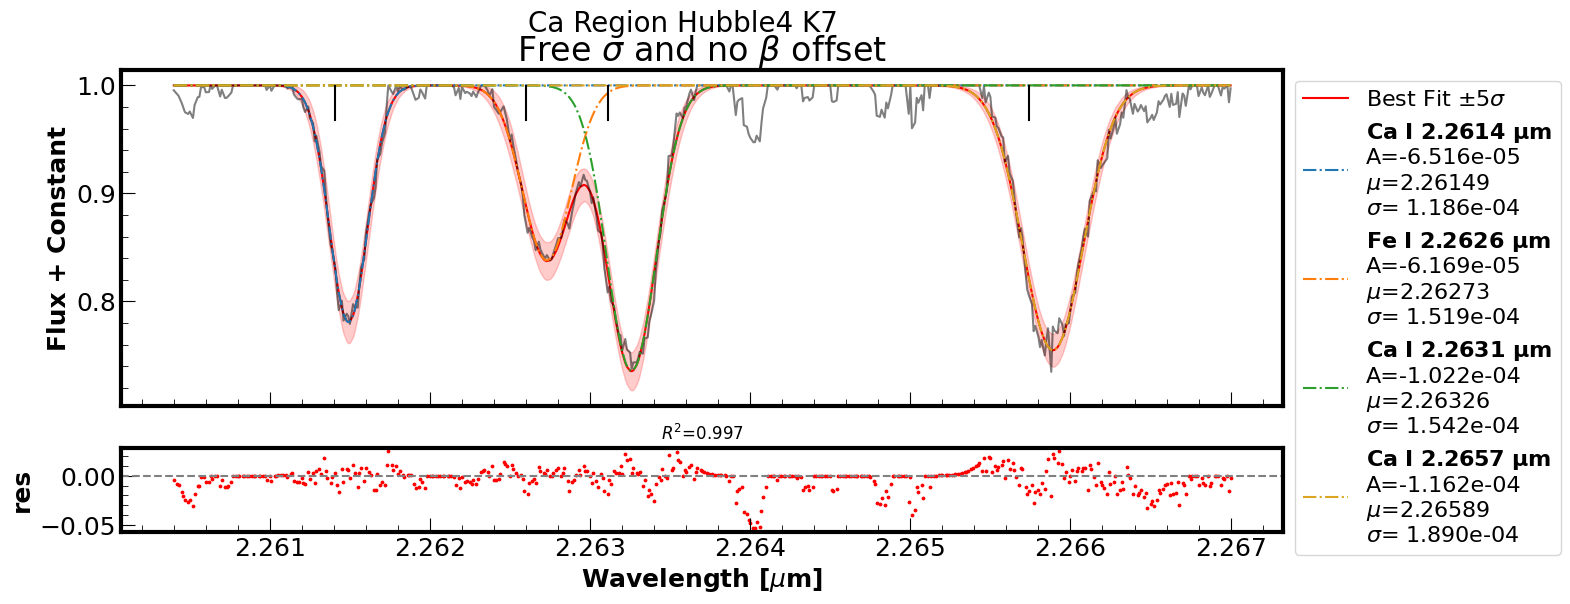

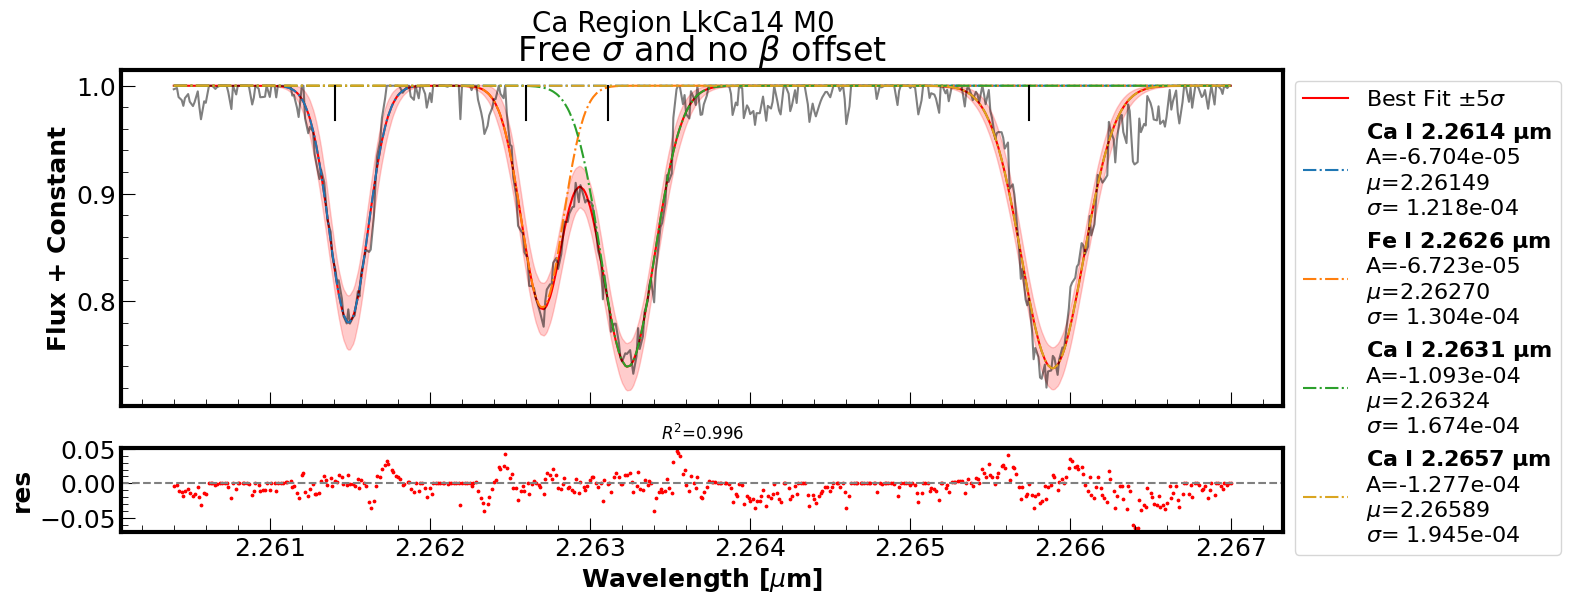

In [5]:
# Initialize storage lists
params_stack = []
beta_stack = []
params_error_stack = []
best_model_stack = []
result_stack = []
dely_stack = []

# For testing purposes
mean_sigma_stack = []

# ca_obs = ca_lines*(1+standard_table['v/c'][0]) # observed wavelengths (theoretically)

for i in range(len(standard_table)):    
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = -1e-5, max = 0)
    params.add('c1', value = ca_reg_lines[0])
    params.add('std1', value = spec_res)

    params.add('amp2', value = -1e-5, max = 0)
    params.add('c2', value = ca_reg_lines[1])
    params.add('std2', value = spec_res)

    params.add('amp3', value = -1e-5, max = 0)
    params.add('c3', value = ca_reg_lines[2])
    params.add('std3', value = spec_res)

    params.add('amp4', value = -1e-5, max = 0)
    params.add('c4', value = ca_reg_lines[3])
    params.add('std4', value = spec_res)

    # tweak lab wavelengths
    # params['c1'].expr = f'{ca_reg_lines[0]} - {5*spec_res}'
    # params['c2'].expr = f'{ca_reg_lines[1]}'
    # params['c3'].expr = f'{ca_reg_lines[2]}'
    # params['c4'].expr = f'{ca_reg_lines[3]}'

    # params.add('beta', value=1.) # beta = (1+v/c)

    # params['std1'].expr = 'std4' # constrain widths to be the same
    # params['std2'].expr = 'std4'
    # params['std3'].expr = 'std4'

    # Define Model
    model = Model(ig.four_gaussian, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                    #    weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=5) # lmfit uncertainty
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std2'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std3'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std4'].value])
    # beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std2'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std3'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std4'].stderr])

    best_model_stack.append(result.best_fit)
    mean_sigma_stack.append(np.mean(a=(result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)))
    
    # print(result.fit_report())
    # print(f"Widths: {result.params['std1'].value:.8f}, {result.params['std2'].value:.8f}, {result.params['std3'].value:.8f}, {result.params['std4'].value:.8f}")
    # print(f"Mean Width: {np.mean(a= (result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)):.8f}")

params_arr = np.array(params_stack)
# 0: amplitude
# 1: centers
# 2: sigmas
amps = params_arr[0::3] # grab every amplitude
amps_err = params_error_stack[0::3]

centers = params_arr[1::3] # grab every center wavelength
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3] # grab every sigma
sigmas_err = params_error_stack[2::3]

# print(centers)
# Gaussian model fits for each source
ca1_2_2614_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []
fe1_2_2626_fits = []
num_gauss = 4

# # Getting the individual Gaussians into their own lists
for i in range(len(standard_table)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i], sigmas[0::num_gauss][i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i], sigmas[1::num_gauss][i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i], sigmas[2::num_gauss][i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i], sigmas[3::num_gauss][i]))
    

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', label=r'Best Fit $\pm 5 \sigma$')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], c='black', alpha=0.5)

    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                    best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                    alpha=0.2, color = 'red' )

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2614~\mu m}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}"  "\n" rf"$\mu$={centers[0::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")
    # rf"$\pm {amps_err[0::num_gauss][i]:.3e}$"
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i], ls='-.',
        label=r'$\bf{Fe~I~2.2626~\mu m}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2631~\mu m}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i], ls='-.', color='goldenrod',
        label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")
    
    for j in range(len(ca_reg_lines)):
        ax1.axvline(ca_reg_lines[j], ymin=0.85, ymax=0.95, color='black')
    
    plt.suptitle(rf"Ca Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_title(r'Free $\sigma$ and no $\beta$ offset')

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    sqsum_res = np.sum(residuals**2)
    sqsum = np.sum((norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2))
    R2 = 1-(sqsum_res/sqsum)

    # Plot residuals
    ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf'$R^2$={R2:.3f}', fontsize=12)

    plt.show()

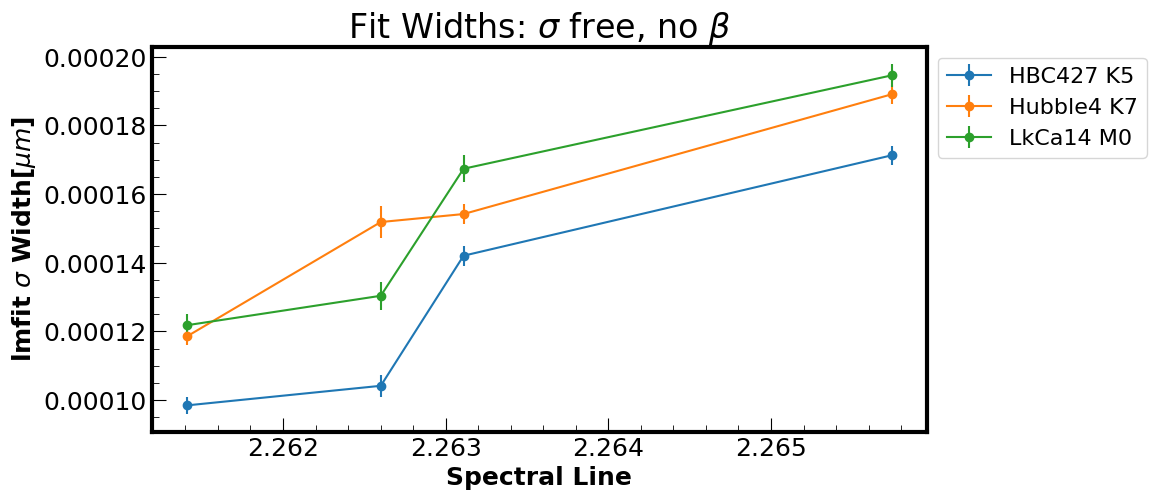

In [6]:
fig = plt.figure(figsize=(10,5))
for i in range(len(standard_table)):
    plt.errorbar(ca_reg_lines, sigmas[i*num_gauss:(i+1)*num_gauss],yerr=sigmas_err[i*num_gauss:(i+1)*num_gauss],
                marker='o', label=f"{standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    # for j in range(len(ca_reg_lines)):
    #     plt.axvline(ca_reg_lines[j], ls='-', ymin=0.82, ymax=0.87, color='black')
    # plt.axhline(mean_sigma_stack[i], xmin=0.1, xmax=0.15, ls=':',color='black', label=rf'Avg $\sigma$' if i==0 else None)
    
    # plt.xlim(left=-0.5)
    # plt.ylim(0.00008,0.00025)
    plt.ylabel(r"lmfit $\sigma$ Width[$\mu m$]")
    plt.xlabel('Spectral Line')
    plt.title(r"Fit Widths: $\sigma$ free, no $\beta$")

    plt.legend(bbox_to_anchor=(1,1))

In [7]:
fract_sigma_stack = []

for i in range(len(standard_table)):
    fract_sigma = sigmas[i*4:(i+1)*4]/mean_sigma_stack[i] # fractional widths
    # print(f"Source {i+1} Widths: {sigmas[i*4:(i+1)*4]}" "\n" f"Avg. Width: {mean_sigma_stack[i]:.8f}")
    # print(f"Source {i+1} Fractional Widths (sigma/sigma_avg): {sigmas[i*4:(i+1)*4]/mean_sigma_stack[i]}" "\n")
    fract_sigma_stack.append(fract_sigma)

In [8]:
mean_sigma_stack

[0.00012899982755851618, 0.0001534069747109806, 0.0001535266419085564]

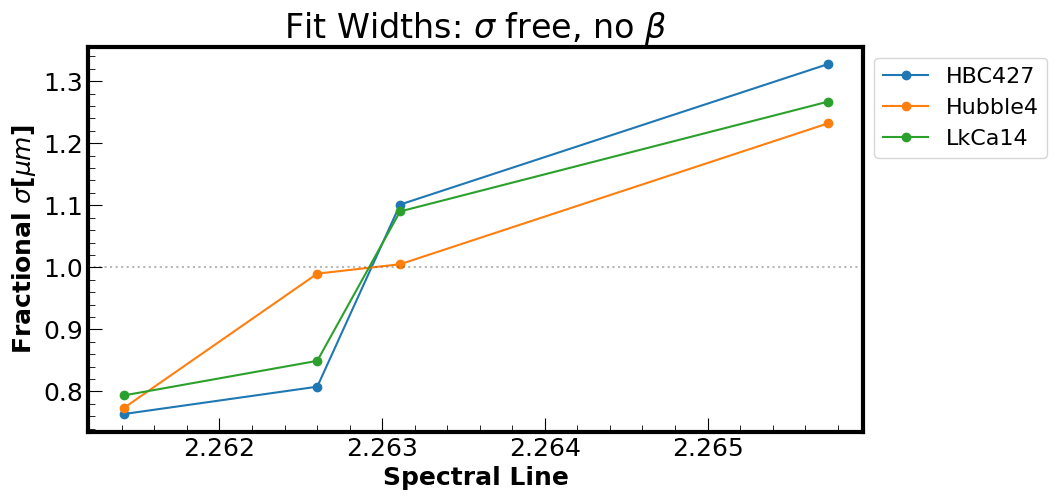

In [9]:
fig = plt.figure(figsize=(10,5))
for i in range(len(standard_table)):
    # plotting the width of each line verses the average width of each source
    # plt.plot(ca_reg_lines,sigmas[i*num_gauss:(i+1)*num_gauss]/mean_sigma_stack[i], marker='o', ls='-', label=f"{standard_table['Name'][i]}")
    plt.plot(ca_reg_lines,fract_sigma_stack[i], marker='o', ls='-', label=f"{standard_table['Name'][i]}")
    plt.axhline(1, ls=":", color='k', alpha=0.1)

    plt.ylabel(r"Fractional $\sigma$[$\mu m$]")
    plt.xlabel('Spectral Line')
    plt.title(r'$\sigma_n/\sigma_{avg}$')
    plt.title(r"Fit Widths: $\sigma$ free, no $\beta$")

    plt.legend(bbox_to_anchor=(1,1))

In [10]:
# # arrays of widths for each line for each standard
# sigma_1_arr = sigmas[0::4] # widths of line 1 for each standard
# sigma_2_arr = sigmas[1::4] # widths of line 2 for each standard
# sigma_3_arr = sigmas[2::4] # widths of line 3 for each standard
# sigma_4_arr = sigmas[3::4] # widths of line 4 for each standard

# sigma_list = [sigma_1_arr, sigma_2_arr, sigma_3_arr, sigma_4_arr]

# for i in range(len(standard_table)):
#     for j in range(len(sigma_list)):
#         print(f"Width for line {j} in {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}: {np.mean(sigma_list[j]):.4e}")
#     # print("", /np.mean(sigmas[]))

In [11]:
for i in range(len(standard_table)):
  print('Method 1 Difference in delta lambdas') 
  # lambda_lab - lambda_fit  
  # lambda_lab - lambda_lab_ref)
  print(f'Using Ca I 2.265741 (lab) micron as reference:')
  print(f'delta difference 1 = {np.abs(centers[0::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[0]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[0::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[0]):.7f}')

  print(f'delta difference 2 = {np.abs(centers[1::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[1]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[1::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[1]):.7f}')

  print(f'delta difference 3 = {np.abs(centers[2::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[2]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[2::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[2]):.7f}')

  print(f'delta difference 4 = {np.abs(centers[3::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[3]}'
    ' = ' f'{np.abs(np.abs(centers[3::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[3]):.7f}' '\n')

Method 1 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0043901 - 0.0043310 = 0.0000591
delta difference 2 = 0.0031734 - 0.0031400 = 0.0000334
delta difference 3 = 0.0026429 - 0.0026310 = 0.0000119
delta difference 4 = 0.0000000 - 0.0 = 0.0000000

Method 1 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0043990 - 0.0043310 = 0.0000680
delta difference 2 = 0.0031602 - 0.0031400 = 0.0000202
delta difference 3 = 0.0026320 - 0.0026310 = 0.0000010
delta difference 4 = 0.0000000 - 0.0 = 0.0000000

Method 1 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0043967 - 0.0043310 = 0.0000657
delta difference 2 = 0.0031872 - 0.0031400 = 0.0000472
delta difference 3 = 0.0026537 - 0.0026310 = 0.0000227
delta difference 4 = 0.0000000 - 0.0 = 0.0000000



## Method 2

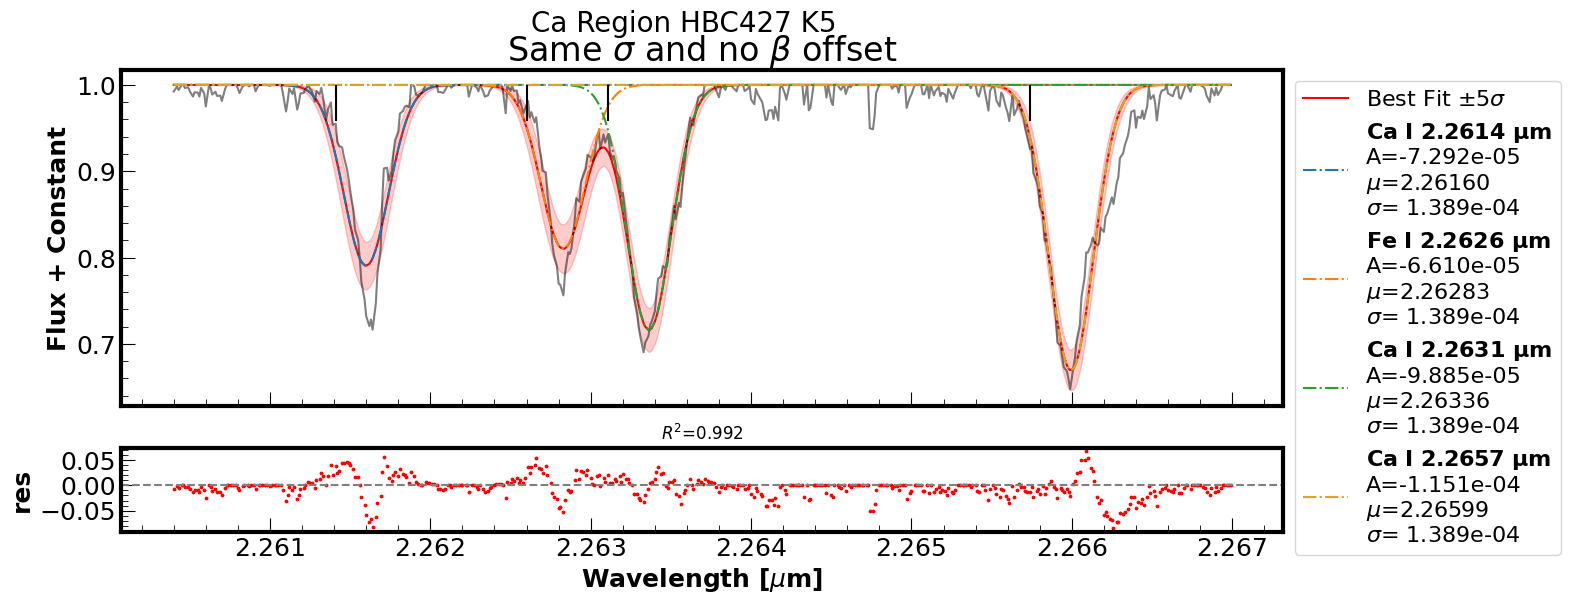

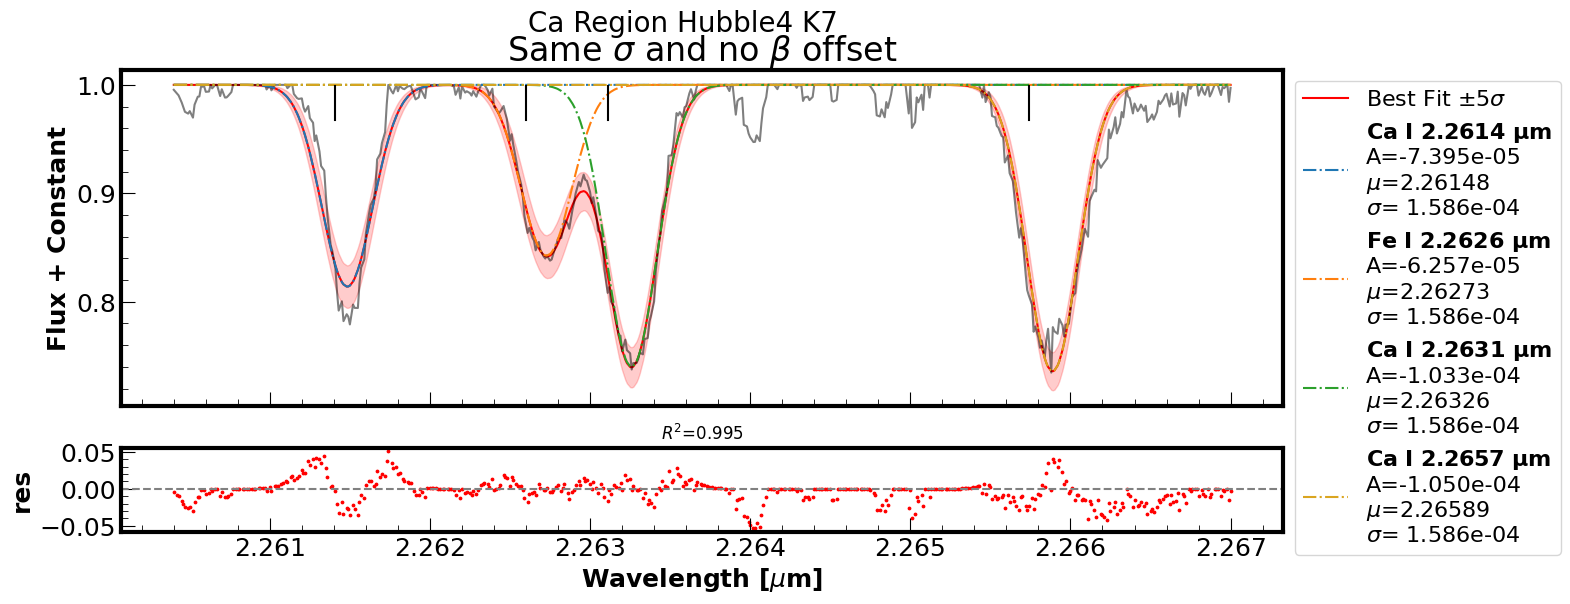

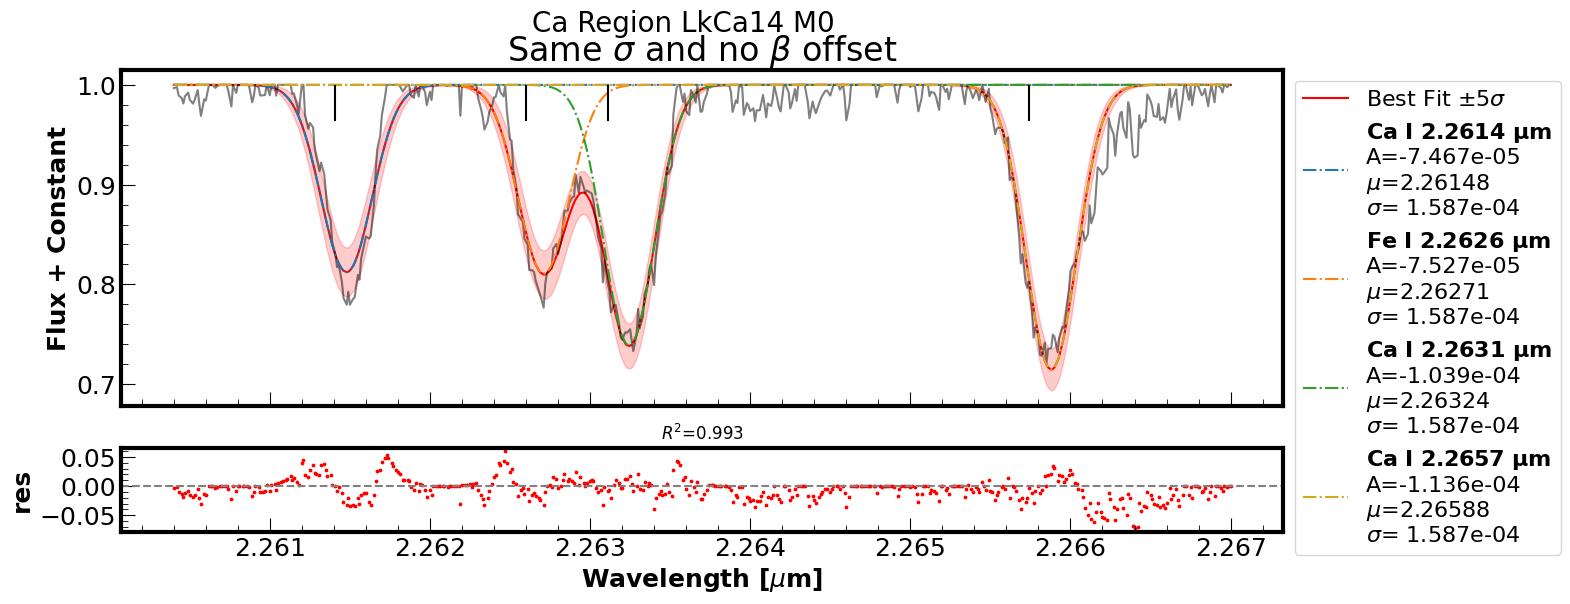

In [12]:
# Initialize storage lists
params_stack = []
beta_stack = []
params_error_stack = []
best_model_stack = []
result_stack = []
dely_stack = []

# ca_obs = ca_lines*(1+standard_table['v/c'][0]) # observed wavelengths (theoretically)

for i in range(len(standard_table)):    
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = -1e-5, max = 0)
    params.add('c1', value = ca_reg_lines[0])
    params.add('std1', value = spec_res)

    params.add('amp2', value = -1e-5, max = 0)
    params.add('c2', value = ca_reg_lines[1])
    params.add('std2', value = spec_res)

    params.add('amp3', value = -1e-5, max = 0)
    params.add('c3', value = ca_reg_lines[2])
    params.add('std3', value = spec_res)

    params.add('amp4', value = -1e-5, max = 0)
    params.add('c4', value = ca_reg_lines[3])
    params.add('std4', value = spec_res)

    # tweak lab wavelengths
    # params['c1'].expr = f'{ca_reg_lines[0]} - {5*spec_res}'
    # params['c2'].expr = f'{ca_reg_lines[1]}'
    # params['c3'].expr = f'{ca_reg_lines[2]}'
    # params['c4'].expr = f'{ca_reg_lines[3]}'

    # params.add('beta', value=1.) # beta = (1+v/c)

    params['std1'].expr = 'std4' # constrain widths to be the same
    params['std2'].expr = 'std4'
    params['std3'].expr = 'std4'

    # Define Model
    model = Model(ig.four_gaussian, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i],
                       weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=5) # lmfit uncertainty
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std2'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std3'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std4'].value])
    # beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std2'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std3'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std4'].stderr])

    best_model_stack.append(result.best_fit)
    # print(params['std1'], params['std2'], params['std3'], params['std4'])

params_arr = np.array(params_stack)

amps = params_arr[0::3] # grab every 3rd amplitude
amps_err = params_error_stack[0::3]

centers = params_arr[1::3] # grab every 3rd center wavelength
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3] # grab every 3rd sigma
sigmas_err = params_error_stack[2::3]

# print(centers)
# Gaussian model fits for each source
ca1_2_2614_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []
fe1_2_2626_fits = []
num_gauss = 4

# # Getting the individual Gaussians into their own lists
for i in range(len(standard_table)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i], sigmas[0::num_gauss][i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i], sigmas[1::num_gauss][i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i], sigmas[2::num_gauss][i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i], sigmas[3::num_gauss][i]))
    

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', label=r'Best Fit $\pm 5 \sigma$')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], c='black', alpha=0.5)

    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                    best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                    alpha=0.2, color = 'red' )

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2614~\mu m}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[0::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i], ls='-.',
        label=r'$\bf{Fe~I~2.2626~\mu m}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2631~\mu m}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i], ls='-.', color='goldenrod',
        label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")
    for j in range(len(ca_reg_lines)):
        ax1.axvline(ca_reg_lines[j], ymin=0.85, ymax=0.95, color='black')
    # plt.axvline()
    plt.suptitle(rf"Ca Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_title(r'Same $\sigma$ and no $\beta$ offset')

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    sqsum_res = np.sum(residuals**2)
    sqsum = np.sum((norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2))
    R2 = 1-(sqsum_res/sqsum)

    # Plot residuals
    ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf'$R^2$={R2:.3f}', fontsize=12)

    plt.show()
    # for ii in range(len(ca_reg_lines)):

In [13]:
for i in range(len(standard_table)):
    print(sigmas[i*4:(i+1)*4]) # the 4 widths for Ca Region per source with little-to-no blending

[0.00013895 0.00013895 0.00013895 0.00013895]
[0.00015859 0.00015859 0.00015859 0.00015859]
[0.00015866 0.00015866 0.00015866 0.00015866]


In [14]:
for i in range(len(standard_table)):
  print('Method 2 Difference in delta lambdas') 
  # lambda_lab - lambda_fit  
  # lambda_lab - lambda_lab_ref)
  print(f'Using Ca I 2.265741 (lab) micron as reference:')
  print(f'delta difference 1 = {np.abs(centers[0::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[0]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[0::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[0]):.7f}')

  print(f'delta difference 2 = {np.abs(centers[1::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[1]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[1::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[1]):.7f}')

  print(f'delta difference 3 = {np.abs(centers[2::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[2]:.7f}'
    ' = ' f'{np.abs(np.abs(centers[2::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[2]):.7f}')

  print(f'delta difference 4 = {np.abs(centers[3::num_gauss][i] - centers[3::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[-1])[3]}'
    ' = ' f'{np.abs(np.abs(centers[3::num_gauss][i] - centers[3::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[-1])[3]):.7f}' '\n')

Method 2 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0043954 - 0.0043310 = 0.0000644
delta difference 2 = 0.0031667 - 0.0031400 = 0.0000267
delta difference 3 = 0.0026317 - 0.0026310 = 0.0000007
delta difference 4 = 0.0000000 - 0.0 = 0.0000000

Method 2 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0044041 - 0.0043310 = 0.0000731
delta difference 2 = 0.0031597 - 0.0031400 = 0.0000197
delta difference 3 = 0.0026287 - 0.0026310 = 0.0000023
delta difference 4 = 0.0000000 - 0.0 = 0.0000000

Method 2 Difference in delta lambdas
Using Ca I 2.265741 (lab) micron as reference:
delta difference 1 = 0.0044010 - 0.0043310 = 0.0000700
delta difference 2 = 0.0031690 - 0.0031400 = 0.0000290
delta difference 3 = 0.0026361 - 0.0026310 = 0.0000051
delta difference 4 = 0.0000000 - 0.0 = 0.0000000



### 7/31/24 

compare methods of fitting (letting things float vs fixing them) \
compare fitted delta_lam vs lab delta_lam

consider printing offsets in centers from my original fitting method where centers are free and the new method where we fix the centers to be equal to lab wavelengths

lab wavelengths might be slightly off hence the need for all this

fit without beta, calculate the deltas using a high S/N line as the reference then fiddle with the lab wavelengths afterwards

### 8/5
test the delta lam for the not blended lines

Compare offset values between lab and fit values for the spectra with good composite fits
	so pick the ***good spectra*** and average the deltas of the deltas

look at the fractional sigmas of the fits (sigma/sigma_avg) where sigma is free parameter

should we really assume sigmas should be the same for all lines???

## Method 3

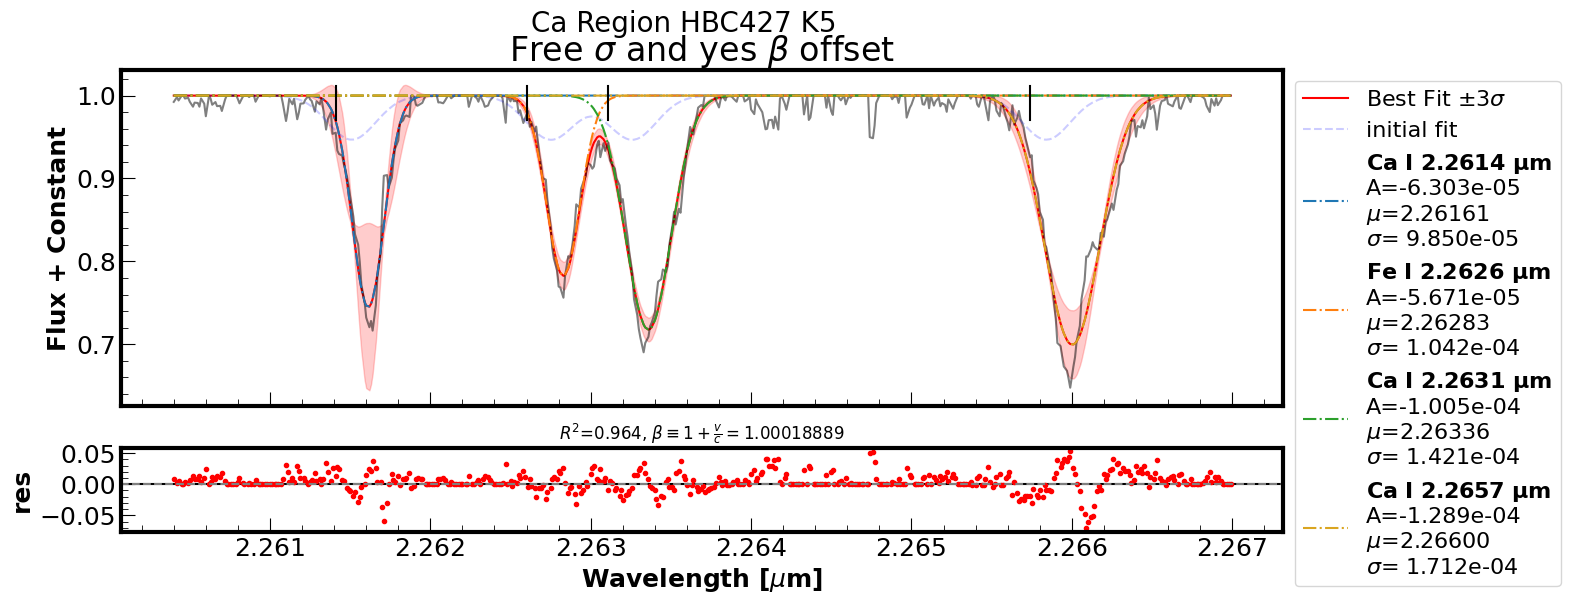

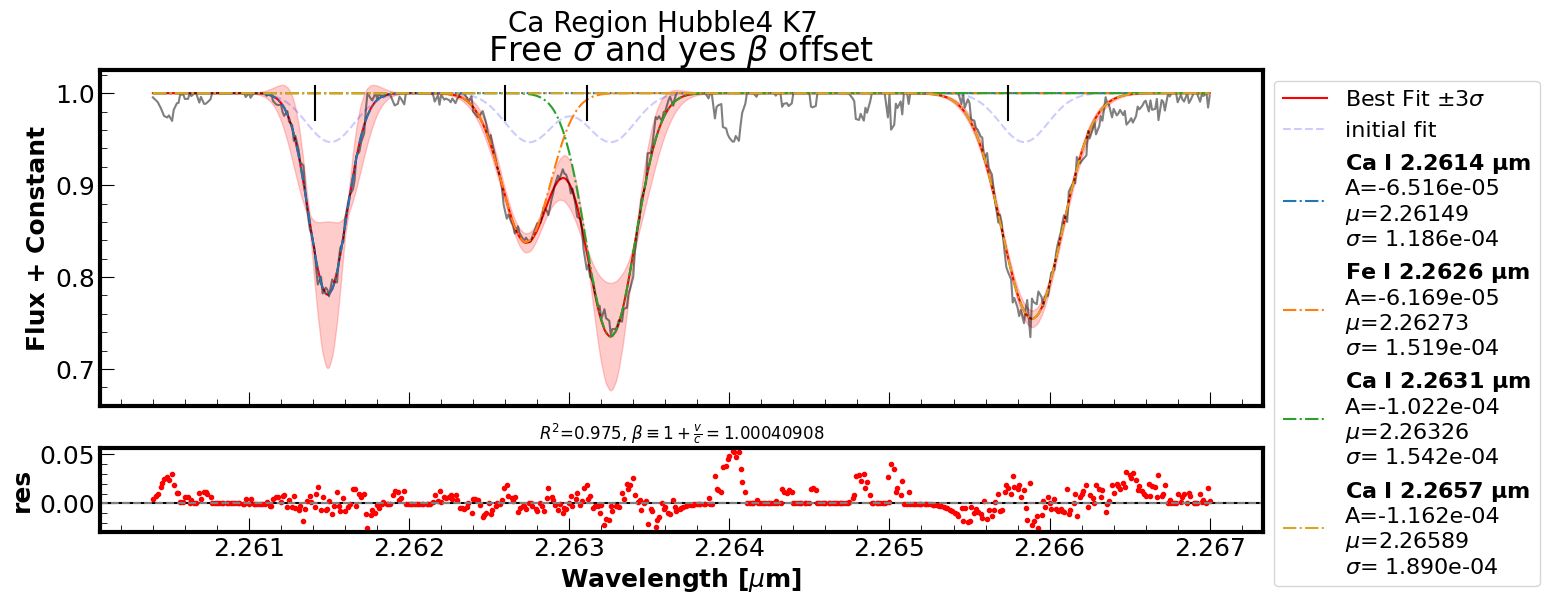

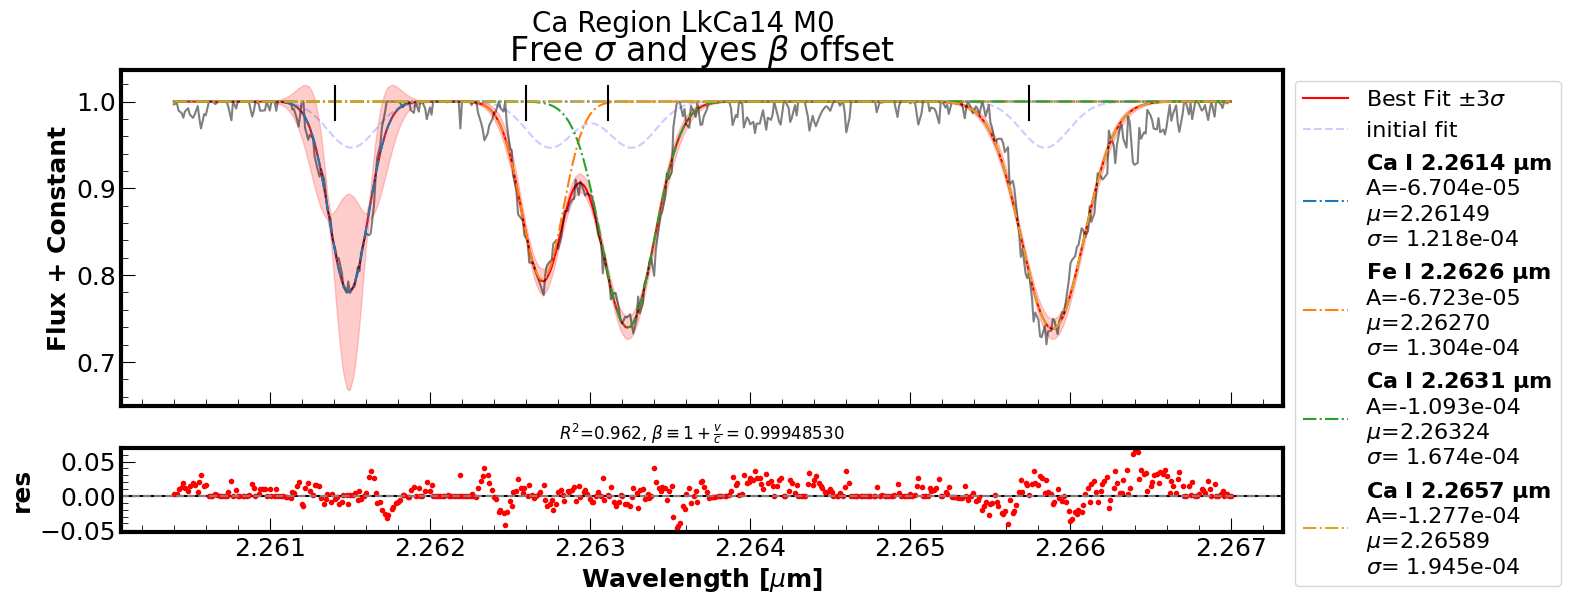

In [15]:
# Initialize storage lists
params_stack = []
beta_stack = []

params_error_stack = []

best_model_stack = []
result_stack = []
dely_stack = []

# For testing purposes
mean_sigma_stack = []

# ca_obs = ca_lines*(1+standard_table['v/c'][0]) # observed wavelengths (theoretically)

for i in range(len(standard_table)):    
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = -2e-5, max = 0)
    params.add('c1', value = ca_reg_lines[0]+10*spec_res)
    params.add('std1', value = 1.5e-4)

    params.add('amp2', value = -2e-5, max = 0)
    params.add('c2', value = ca_reg_lines[1]+15*spec_res)
    params.add('std2', value = 1.5e-4)

    params.add('amp3', value = -2e-5, max = 0)
    params.add('c3', value = ca_reg_lines[2]+15*spec_res)
    params.add('std3', value = 1.5e-4)

    params.add('amp4', value = -2e-5, max = 0)
    params.add('c4', value = ca_reg_lines[3]+10*spec_res)
    params.add('std4', value = 1.5e-4)


    # make sure centers are in order
    # params['c2'].expr = 'c2 < c3'
    # params['c3'].expr =
    # params['c4'].expr =
    # tweak lab wavelengths
    # params['c1'].expr = f'{ca_reg_lines[0]}'
    # params['c2'].expr = f'{ca_reg_lines[1]}'
    # params['c3'].expr = f'{ca_reg_lines[2]}'
    # params['c4'].expr = f'{ca_reg_lines[3]}'

    params.add('beta', value=1.) # beta = (1+v/c)

    # params['std1'].expr = 'std4' # constrain widths to be the same
    # params['std2'].expr = 'std4'
    # params['std3'].expr = 'std4'

    # Define Model
    model = Model(ig.four_gaussian_beta, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                    #    weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit uncertainty
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std2'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std3'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std4'].value])

    beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std2'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std3'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std4'].stderr])

    best_model_stack.append(result.best_fit)
    mean_sigma_stack.append(np.mean(a=(result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)))

    # print(result.fit_report())
    # print(f"Widths: {result.params['std1'].value:.8f}, {result.params['std2'].value:.8f}, {result.params['std3'].value:.8f}, {result.params['std4'].value:.8f}")
    # print(f"Mean Width: {np.mean(a= (result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)):.8f}")

params_arr = np.array(params_stack)
# 0: amplitude
# 1: centers
# 2: sigmas
amps = params_arr[0::3] # grab every amplitude
amps_err = params_error_stack[0::3]

centers = params_arr[1::3] # grab every center wavelength
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3] # grab every sigma
sigmas_err = params_error_stack[2::3]

# print(centers)
# Gaussian model fits for each source
ca1_2_2614_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []
fe1_2_2626_fits = []
num_gauss = 4

# # Getting the individual Gaussians into their own lists
for i in range(len(standard_table)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i]*beta_stack[i], sigmas[0::num_gauss][i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i]*beta_stack[i], sigmas[1::num_gauss][i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i]*beta_stack[i], sigmas[2::num_gauss][i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i]*beta_stack[i], sigmas[3::num_gauss][i]))
    

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table)):
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', label=r'Best Fit $\pm 3 \sigma$')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], c='black', alpha=0.5)
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], result_stack[i].init_fit, '--', c='blue' , alpha=0.2, label='initial fit')

    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                    best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                    alpha=0.2, color = 'red' )

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2614~\mu m}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[0::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")
    # rf"$\pm {amps_err[0::num_gauss][i]:.3e}$"
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i], ls='-.',
        label=r'$\bf{Fe~I~2.2626~\mu m}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2631~\mu m}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i], ls='-.', color='goldenrod',
        label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")
    
    for j in range(len(ca_reg_lines)):
        ax1.axvline(ca_reg_lines[j], ymin=0.85, ymax=0.95, color='black')
    
    plt.suptitle(rf"Ca Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_title(r'Free $\sigma$ and yes $\beta$ offset')

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    # sqsum_res = np.sum(residuals**2)
    # sqsum = np.sum((norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2))
    # R2 = 1-(sqsum_res/sqsum)

    # Plot residuals
    # ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    result_stack[i].plot_residuals(ax=ax2, datafmt='r.')
    
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf"$R^2$={result_stack[i].rsquared:.3f}, " r'$\beta \equiv 1+\frac{v}{c}= $' f"{beta_stack[i]:.8f}", fontsize=12)

    plt.show()

In [16]:
for i in range(len(standard_table)):
    print(sigmas[i*4:(i+1)*4]) # the 4 widths for Ca Region per source with little-to-no blending

[9.84970955e-05 1.04187035e-04 1.42051994e-04 1.71222295e-04]
[0.00011858 0.00015185 0.00015418 0.00018902]
[0.00012183 0.00013039 0.00016736 0.00019453]


In [17]:
fract_sigma_stack = []

for i in range(len(standard_table)):
    fract_sigma = sigmas[i*4:(i+1)*4]/mean_sigma_stack[i] # fractional widths
    print(f"Source {i+1} Widths: {sigmas[i*4:(i+1)*4]}" "\n" f"Avg. Width: {mean_sigma_stack[i]:.8f}")
    print(f"Source {i+1} Fractional Widths (sigma/sigma_avg): {sigmas[i*4:(i+1)*4]/mean_sigma_stack[i]}" "\n")
    fract_sigma_stack.append(fract_sigma)
print(f'Average of avg width: {np.mean(mean_sigma_stack):.8f}')

Source 1 Widths: [9.84970955e-05 1.04187035e-04 1.42051994e-04 1.71222295e-04]
Avg. Width: 0.00012899
Source 1 Fractional Widths (sigma/sigma_avg): [0.76360491 0.80771652 1.10126699 1.32741158]

Source 2 Widths: [0.00011858 0.00015185 0.00015418 0.00018902]
Avg. Width: 0.00015341
Source 2 Fractional Widths (sigma/sigma_avg): [0.77298994 0.98986544 1.00502855 1.23211607]

Source 3 Widths: [0.00012183 0.00013039 0.00016736 0.00019453]
Avg. Width: 0.00015353
Source 3 Fractional Widths (sigma/sigma_avg): [0.79351132 0.8492958  1.09010885 1.26708402]

Average of avg width: 0.00014531


In [18]:
# fig = plt.figure(figsize=(15,5))
# for i in range(len(standard_table)):
#     plt.errorbar(ca_reg_lines, sigmas[i*num_gauss:(i+1)*num_gauss], yerr=sigmas_err[i*num_gauss:(i+1)*num_gauss],
#                 marker='o', label=f"{standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

#     # for j in range(len(ca_reg_lines)):
#     #     plt.axvline(ca_reg_lines[j], ls='-', ymin=0.82, ymax=0.87, color='black')
#     # plt.axhline(mean_sigma_stack[i], xmin=0.1, xmax=0.15, ls=':',color='black', label=rf'Avg $\sigma$' if i==0 else None)

#     # plt.xlim(left=-0.5)
#     # plt.ylim(0.00008,0.00025)
#     plt.ylabel(r"lmfit $\sigma$ Width[$\mu m$]")
#     plt.xlabel('Spectral Line')
#     plt.title(r"Free $\sigma$ w/ Fit Widths")

#     plt.legend(bbox_to_anchor=(1,1))

In [19]:
# fig = plt.figure(figsize=(15,5))
# for i in range(len(standard_table)):
#     # plotting the width of each line verses the average width of each source
#     # plt.plot(ca_reg_lines,sigmas[i*num_gauss:(i+1)*num_gauss]/mean_sigma_stack[i], marker='o', ls='-', label=f"{standard_table['Name'][i]}")
#     plt.plot(ca_reg_lines,fract_sigma_stack[i], marker='o', ls='-', label=f"{standard_table['Name'][i]}")
#     plt.axhline(1, ls=":", color='k', alpha=0.1)

#     plt.ylabel(r"Fractional $\sigma$[$\mu m$]")
#     plt.xlabel('Spectral Line')
#     plt.title(r'$\sigma_n/\sigma_{avg}$')

#     plt.legend(bbox_to_anchor=(1,1))

In [20]:
# # arrays of widths for each line for each standard
# sigma_1_arr = sigmas[0::4] # widths of line 1 for each standard
# sigma_2_arr = sigmas[1::4] # widths of line 2 for each standard
# sigma_3_arr = sigmas[2::4] # widths of line 3 for each standard
# sigma_4_arr = sigmas[3::4] # widths of line 4 for each standard

# sigma_list = [sigma_1_arr, sigma_2_arr, sigma_3_arr, sigma_4_arr]

# for i in range(len(standard_table)):
#     for j in range(len(sigma_list)):
#         print(f"Width for line {j} in {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}: {np.mean(sigma_list[j]):.4e}")
#     # print("", /np.mean(sigmas[]))

In [21]:
delt_diff_stack = []
ref_line = 0 # reference spectral feature index

for i in range(len(standard_table)):
    # To store the differences for each spectrum
    delta_diff_spectrum = []
    for j in range(len(ca_reg_lines)):
        # fit line center and ref line center offset
        fit_ref_diff = np.abs(centers[j::num_gauss][i] - centers[ref_line::num_gauss][i])
        # print(fit_ref_diff)
        # lab line center and ref line center offset
        lab_ref_diff = np.abs(ca_reg_lines - ca_reg_lines[ref_line])[j]
        # print(lab_ref_diff)
        # difference between the delta wavelengths
        delta_diff = np.abs(fit_ref_diff - lab_ref_diff)
        # print(delta_diff)
        # append to list of differences for spectrum i
        delta_diff_spectrum.append(delta_diff)
        
    # append the differences for this spectrum to the main list
    delt_diff_stack.append(delta_diff_spectrum)
print(delt_diff_stack)
# only want to keep the best fits, i.e. 0, 1, and 3
# delt_diff_stack = [delt_diff_stack[i] for i in [0, 1, 2]]
# print(delt_diff_stack)


# for i in range(len(standard_table)):
#   print('Method 3 Difference in delta lambdas') 
#   # lambda_lab - lambda_fit  
#   # lambda_lab - lambda_lab_ref)
#   print(f'Using Ca I 2.2614 (lab) micron as reference:')
#   # difference between the fit of line i and fit of reference line
#   # difference between lab and fit center
#   print(f'delta difference 1 = {np.abs(centers[0::num_gauss][i] - centers[ref_line::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[ref_line])[0]:.7f}'
#     ' = ' f'{np.abs(np.abs(centers[0::num_gauss][i] - centers[0::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[0])[0]):.7f}')

#   print(f'delta difference 2 = {np.abs(centers[1::num_gauss][i] - centers[ref_line::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[ref_line])[1]:.7f}'
#     ' = ' f'{np.abs(np.abs(centers[1::num_gauss][i] - centers[0::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[0])[1]):.7f}')

#   print(f'delta difference 3 = {np.abs(centers[2::num_gauss][i] - centers[ref_line::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[ref_line])[2]:.7f}'
#     ' = ' f'{np.abs(np.abs(centers[2::num_gauss][i] - centers[0::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[0])[2]):.7f}')

#   print(f'delta difference 4 = {np.abs(centers[3::num_gauss][i] - centers[ref_line::num_gauss][i]):.7f}' ' - ' f'{np.abs(ca_reg_lines-ca_reg_lines[ref_line])[3]}'
#     ' = ' f'{np.abs(np.abs(centers[3::num_gauss][i] - centers[0::num_gauss][i])-np.abs(ca_reg_lines-ca_reg_lines[0])[3]):.7f}' '\n')

[[0.0, 2.5478960408165108e-05, 4.687295131633462e-05, 5.826341012005187e-05], [0.0, 4.735916632991888e-05, 6.634757596790664e-05, 6.623936095717653e-05], [0.0, 1.9147518221185322e-05, 4.391879891985084e-05, 6.799467993223729e-05]]


In [22]:
line_center_arr = np.empty(shape=(len(standard_table), len(ca_reg_lines)))
for i in range(len(standard_table)):
    line_center_arr[i] = (ca_reg_lines + delt_diff_stack[i])

ca_reg_tweak = np.empty(shape=(len(ca_reg_lines)))

for j in range(len(ca_reg_lines)):
    ca_reg_tweak[j] = np.mean(line_center_arr[:,j])

print("Tweaked Wavelength Array:", line_center_arr)
print("avg:", ca_reg_tweak)


Tweaked Wavelength Array: [[2.26141    2.26262648 2.26315687 2.26579926]
 [2.26141    2.26264836 2.26317635 2.26580724]
 [2.26141    2.26262015 2.26315392 2.26580899]]
avg: [2.26141    2.26263166 2.26316238 2.26580517]


## Tweak Wavlengths

In [23]:
for i in range(len(delt_diff_stack)):
    # average delta
    print(np.mean(delt_diff_stack[i]))
    # gotta do offset for each line individually

3.26538304611379e-05
4.498652581375051e-05
3.2765249268318364e-05


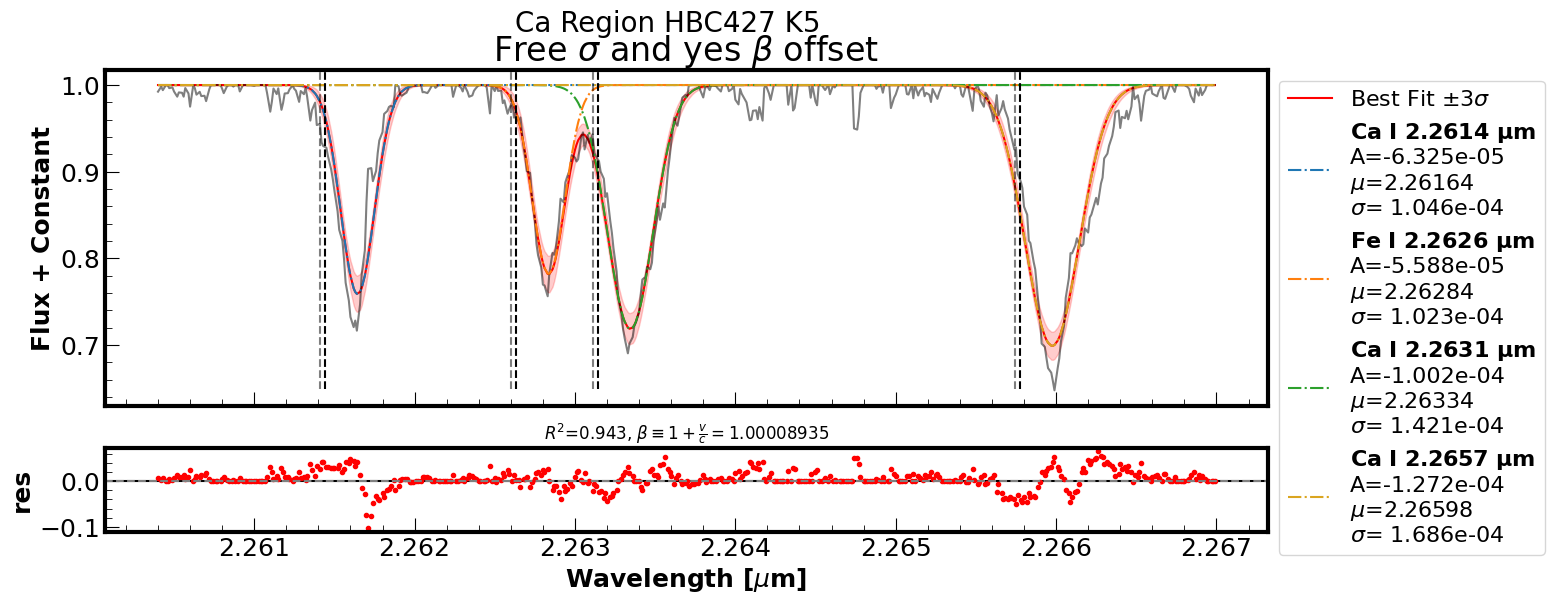

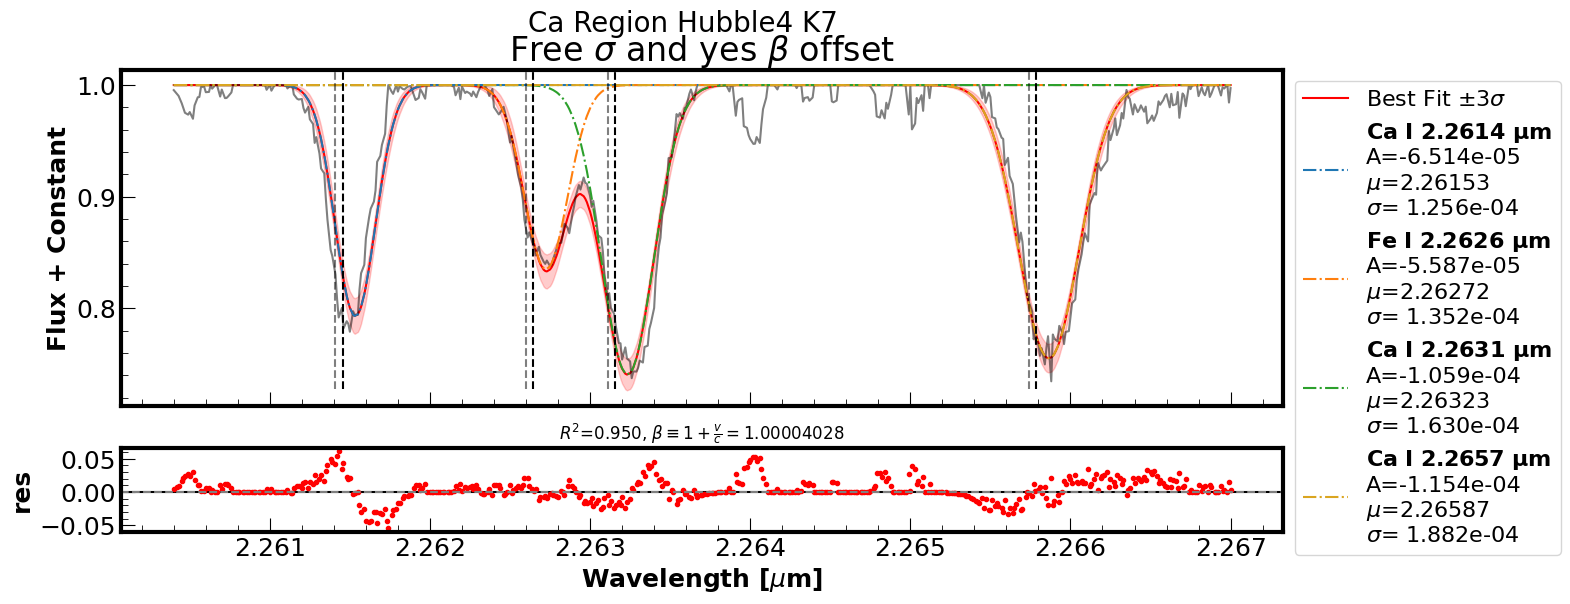

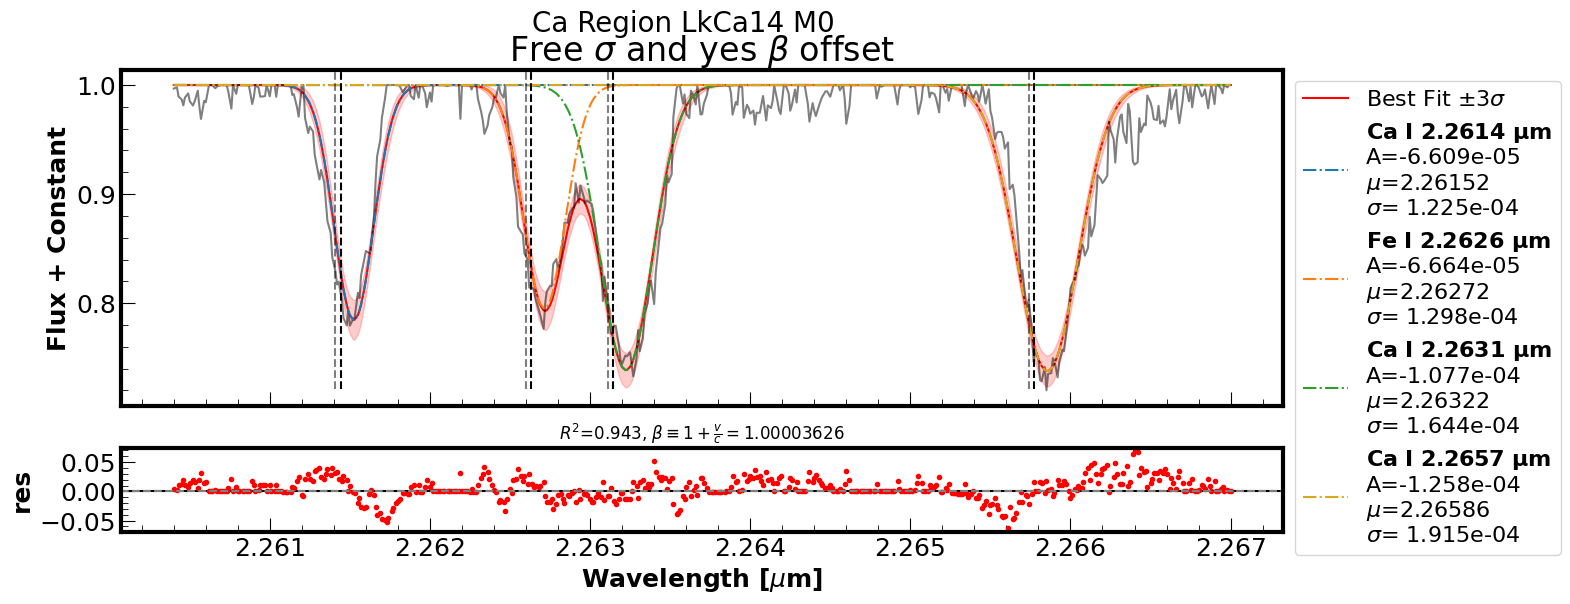

In [30]:
# Initialize storage lists
params_stack = []
beta_stack = []

params_error_stack = []

best_model_stack = []
result_stack = []
dely_stack = []

# For testing purposes
mean_sigma_stack = []

# ca_obs = ca_lines*(1+standard_table['v/c'][0]) # observed wavelengths (theoretically)

for i in range(len(standard_table)):
    # adjust lab wavelengths by the average 
    # ca_reg_tweak = ca_reg_lines + np.mean(delt_diff_stack[i])
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = -2e-5, max = 0)
    params.add('c1', value = ca_reg_tweak[0])
    params.add('std1', value = 1.5e-4)

    params.add('amp2', value = -2e-5, max = 0)
    params.add('c2', value = ca_reg_tweak[1])
    params.add('std2', value = 1.5e-4)

    params.add('amp3', value = -2e-5, max = 0)
    params.add('c3', value = ca_reg_tweak[2])
    params.add('std3', value = 1.5e-4)

    params.add('amp4', value = -2e-5, max = 0)
    params.add('c4', value = ca_reg_tweak[3])
    params.add('std4', value = 1.5e-4)


    # make sure centers are in order
    # params['c2'].expr = 'c2 < c3'
    # params['c3'].expr =
    # params['c4'].expr =

    # tweak lab wavelengths
    params['c1'].expr = f'{ca_reg_tweak[0]}'
    params['c2'].expr = f'{ca_reg_tweak[1]}'
    params['c3'].expr = f'{ca_reg_tweak[2]}'
    params['c4'].expr = f'{ca_reg_tweak[3]}'

    params.add('beta', value=1.) # beta = (1+v/c)

    # params['std1'].expr = 'std4' # constrain widths to be the same
    # params['std2'].expr = 'std4'
    # params['std3'].expr = 'std4'

    # Define Model
    model = Model(ig.four_gaussian_beta, nan_policy='omit')

    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                    #    weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit uncertainty
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std2'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std3'].value,
                         result.params['amp4'].value, result.params['c4'].value, result.params['std4'].value])

    beta_stack.append(result.params['beta'].value)
    
    params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
                               result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std2'].stderr,
                               result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std3'].stderr,
                               result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std4'].stderr])

    best_model_stack.append(result.best_fit)
    mean_sigma_stack.append(np.mean(a=(result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)))

    # print(result.fit_report())
    # print(f"Widths: {result.params['std1'].value:.8f}, {result.params['std2'].value:.8f}, {result.params['std3'].value:.8f}, {result.params['std4'].value:.8f}")
    # print(f"Mean Width: {np.mean(a= (result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)):.8f}")

params_arr = np.array(params_stack)
# 0: amplitude
# 1: centers
# 2: sigmas
amps = params_arr[0::3] # grab every amplitude
amps_err = params_error_stack[0::3]

centers = params_arr[1::3] # grab every center wavelength
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3] # grab every sigma
sigmas_err = params_error_stack[2::3]

# print(centers)
# Gaussian model fits for each source
ca1_2_2614_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []
fe1_2_2626_fits = []
num_gauss = 4

# # Getting the individual Gaussians into their own lists
for i in range(len(standard_table)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i]*beta_stack[i], sigmas[0::num_gauss][i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i]*beta_stack[i], sigmas[1::num_gauss][i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i]*beta_stack[i], sigmas[2::num_gauss][i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i]*beta_stack[i], sigmas[3::num_gauss][i]))
    

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table)):
    ca_reg_tweak = ca_reg_lines + np.mean(delt_diff_stack[i])
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', label=r'Best Fit $\pm 3 \sigma$')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], c='black', alpha=0.5)
    # ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], result_stack[i].init_fit, '--', c='blue' , alpha=0.2, label='initial fit')

    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                    best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                    alpha=0.2, color = 'red' )

    # plot each componenet
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2614~\mu m}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[0::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")
    # rf"$\pm {amps_err[0::num_gauss][i]:.3e}$"
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i], ls='-.',
        label=r'$\bf{Fe~I~2.2626~\mu m}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2631~\mu m}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i], ls='-.', color='goldenrod',
        label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")
    
    for j in range(len(ca_reg_lines)):
        ax1.axvline(ca_reg_lines[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls='--', alpha=0.5)
        ax1.axvline(ca_reg_tweak[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls='--')
        # print(f"Offset from tweaked lab wavelength to fit center for line {j+1}: {np.abs(ca_reg_lines[j]-(ca_reg_tweak[j])):.5e}")
    
    plt.suptitle(rf"Ca Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_title(r'Free $\sigma$ and yes $\beta$ offset')

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    # sqsum_res = np.sum(residuals**2)
    # sqsum = np.sum((norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2))
    # R2 = 1-(sqsum_res/sqsum)

    # Plot residuals
    # ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    result_stack[i].plot_residuals(ax=ax2, datafmt='r.')
    
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf"$R^2$={result_stack[i].rsquared:.3f}, " r'$\beta \equiv 1+\frac{v}{c}= $' f"{beta_stack[i]:.8f}", fontsize=12)

    plt.show()

In [25]:
beta_stack

[1.0000878976756025, 1.0000387424635178, 1.0000349091385885]

In [26]:
line1_amps = amps[0::num_gauss]
line2_amps = amps[1::num_gauss]
line3_amps = amps[2::num_gauss]
line4_amps = amps[3::num_gauss]

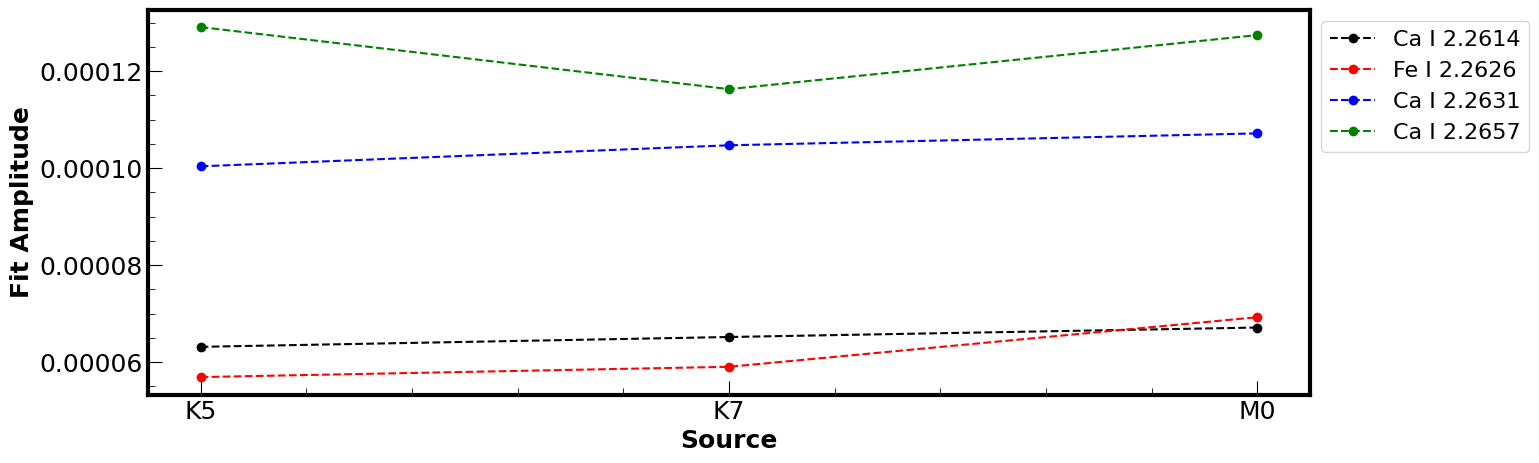

In [27]:
fig = plt.figure(figsize=(15,5))
# for i in range(len(standard_table)):

plt.plot(standard_table['Spectral_Type'], np.abs(line1_amps), ls='--', marker='o', c ='k' , label = 'Ca I 2.2614')
plt.plot(standard_table['Spectral_Type'], np.abs(line2_amps), ls='--', marker='o', c ='red' , label = 'Fe I 2.2626')
plt.plot(standard_table['Spectral_Type'], np.abs(line3_amps), ls='--', marker='o', c ='blue' , label = 'Ca I 2.2631')
plt.plot(standard_table['Spectral_Type'], np.abs(line4_amps), ls='--', marker='o', c ='green' , label = 'Ca I 2.2657')

plt.xlabel('Source')
plt.ylabel('Fit Amplitude')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

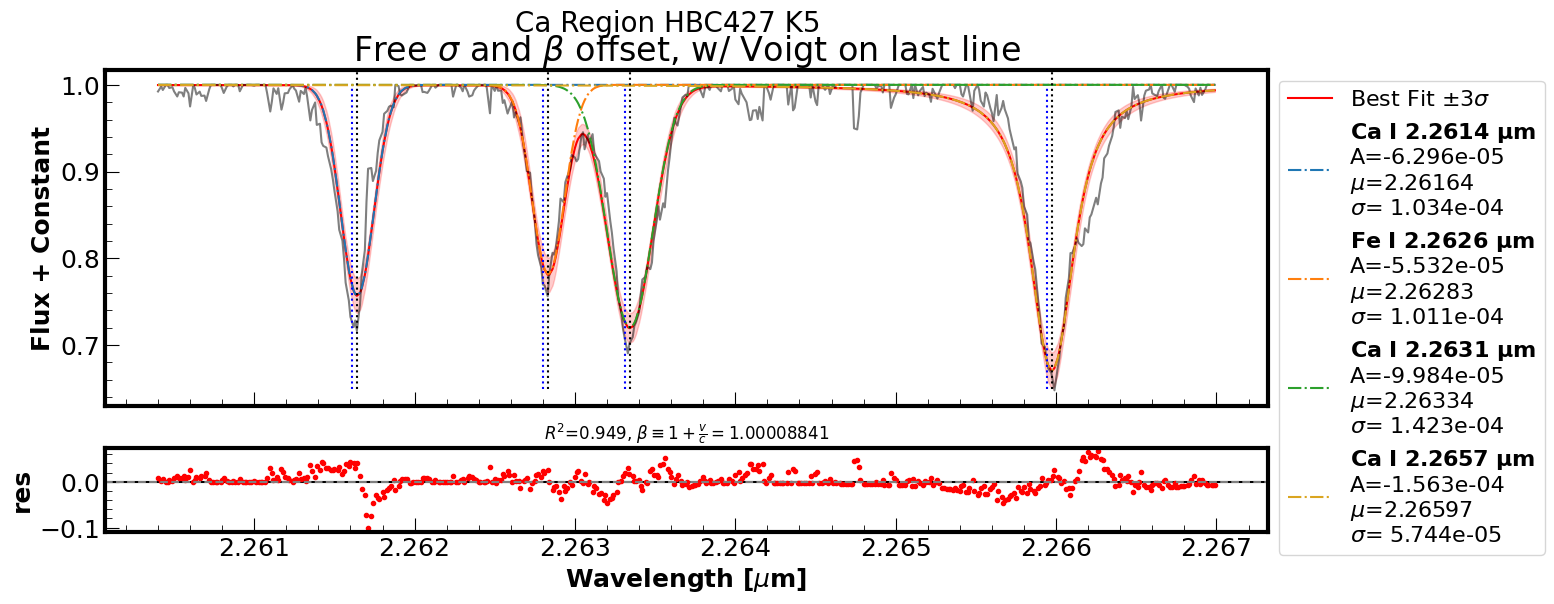

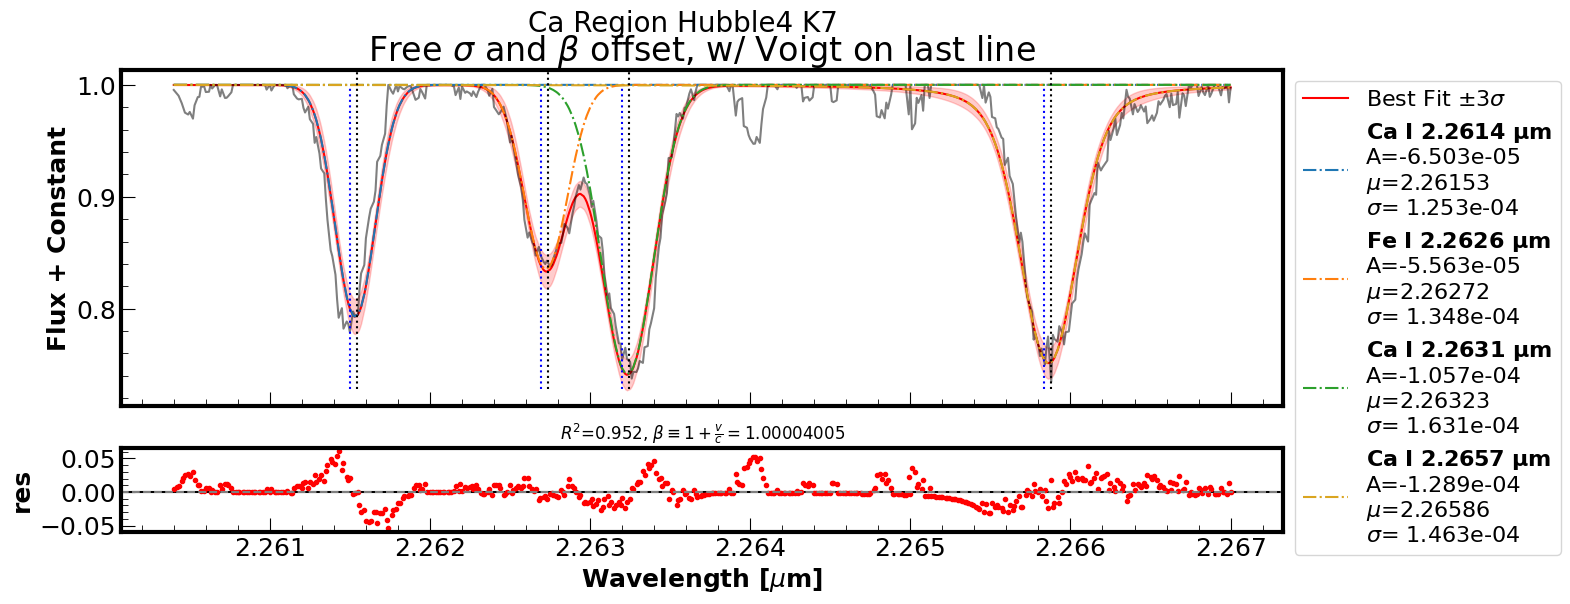

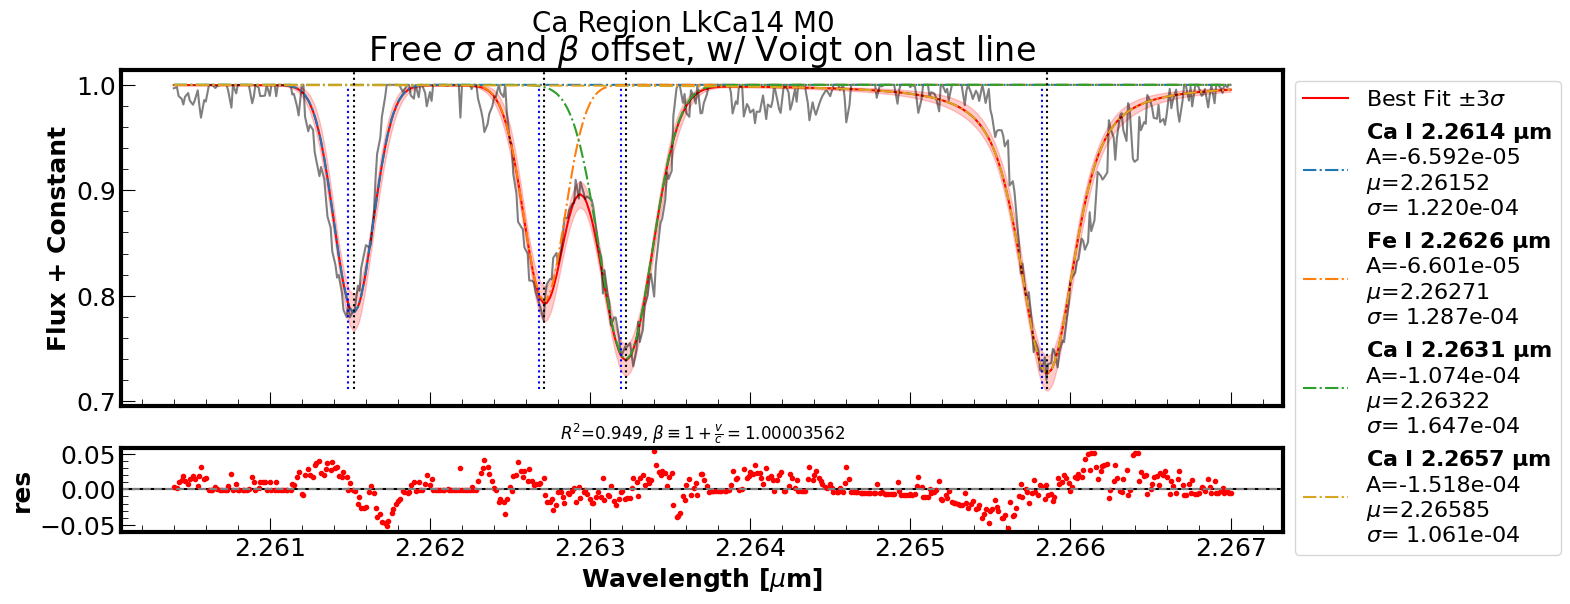

In [28]:
# Initialize storage lists

params_stack = []
beta_stack = []

params_error_stack = []

best_model_stack = []
result_stack = []
dely_stack = []

# For testing purposes
mean_sigma_stack = []

# ca_obs = ca_lines*(1+standard_table['v/c'][0]) # observed wavelengths (theoretically)

for i in range(len(standard_table)):
    # Define Model
    gauss_model = Model(ig.three_gaussian_beta, nan_policy='omit')
    voigt_model = VoigtModel(prefix='v4_')
    model = gauss_model + voigt_model

    # ca_reg_tweak = ca_reg_lines + np.mean(delt_diff_stack[i])
    # Define initial parameters for Gaussian fitting
    params = Parameters()

    params.add('amp1', value = -3e-5, max = 0)
    params.add('c1', value = ca_reg_tweak[0])
    params.add('std1', value = 1.5e-4)

    params.add('amp2', value = -3e-5, max = 0)
    params.add('c2', value = ca_reg_tweak[1])
    params.add('std2', value = 1.5e-4)

    params.add('amp3', value = -3e-5, max = 0)
    params.add('c3', value = ca_reg_tweak[2])
    params.add('std3', value = 1.5e-4)

    # Add parameters for the Voigt profile
    params.add('v4_amplitude', value=-5e-5, max=0)
    params.add('v4_center', value=ca_reg_tweak[3])
    params.add('v4_sigma', value=1.5e-4)
    params.add('v4_gamma', value=1e-5)  # Additional parameter for Voigt


    # make sure centers are in order
    # params['c2'].expr = 'c2 < c3'
    # params['c3'].expr =
    # params['c4'].expr =

    # tweak lab wavelengths
    params['c1'].expr = f'{ca_reg_tweak[0]}'
    params['c2'].expr = f'{ca_reg_tweak[1]}'
    params['c3'].expr = f'{ca_reg_tweak[2]}'
    params['v4_center'].expr = f'{ca_reg_tweak[3]}'

    params.add('beta', value=1.) # beta = (1+v/c)
    # Link the Voigt center to beta
    params['v4_center'].expr = f'{ca_reg_tweak[3]} * beta'


    # params['std1'].expr = 'std4' # constrain widths to be the same
    # params['std2'].expr = 'std4'
    # params['std3'].expr = 'std4'


    result = model.fit(norm_flux_stack[i], params,
                       x = wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])
                    #    weights = 1/raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i])

    result_stack.append(result) # lmfit ModelResult objects
    dely = result.eval_uncertainty(sigma=3) # lmfit uncertainty
    dely_stack.append(dely)

    # Append the best_model, error and parameters stacks
    # could probably make a loop to the tune of for value in result etc...
    params_stack.extend([result.params['amp1'].value, result.params['c1'].value, result.params['std1'].value,
                         result.params['amp2'].value, result.params['c2'].value, result.params['std2'].value,
                         result.params['amp3'].value, result.params['c3'].value, result.params['std3'].value,
                         result.params['v4_amplitude'].value, result.params['v4_center'].value, result.params['v4_sigma'].value])

    beta_stack.append(result.params['beta'].value)
    
    # params_error_stack.extend([result.params['amp1'].stderr, result.params['c1'].stderr, result.params['std1'].stderr,
    #                            result.params['amp2'].stderr, result.params['c2'].stderr, result.params['std2'].stderr,
    #                            result.params['amp3'].stderr, result.params['c3'].stderr, result.params['std3'].stderr,
    #                            result.params['amp4'].stderr, result.params['c4'].stderr, result.params['std4'].stderr])

    best_model_stack.append(result.best_fit)
    mean_sigma_stack.append(np.mean(a =(result.params['std1'].value,
                                        result.params['std2'].value,
                                        result.params['std3'].value,
                                        result.params['v4_sigma'].value)))

    # print(result.fit_report())
    # print(f"Widths: {result.params['std1'].value:.8f}, {result.params['std2'].value:.8f}, {result.params['std3'].value:.8f}, {result.params['std4'].value:.8f}")
    # print(f"Mean Width: {np.mean(a= (result.params['std1'].value, result.params['std2'].value, result.params['std3'].value, result.params['std4'].value)):.8f}")

params_arr = np.array(params_stack)
# 0: amplitude
# 1: centers
# 2: sigmas
amps = params_arr[0::3] # grab every amplitude
amps_err = params_error_stack[0::3]

centers = params_arr[1::3] # grab every center wavelength
center_err = params_error_stack[1::3]

sigmas = params_arr[2::3] # grab every sigma
sigmas_err = params_error_stack[2::3]

# print(centers)
# Gaussian model fits for each source
ca1_2_2614_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []
fe1_2_2626_fits = []
num_gauss = 4

# # Getting the individual Gaussians into their own lists
for i in range(len(standard_table)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[0::num_gauss][i], centers[0::num_gauss][i]*beta_stack[i], sigmas[0::num_gauss][i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[1::num_gauss][i], centers[1::num_gauss][i]*beta_stack[i], sigmas[1::num_gauss][i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[2::num_gauss][i], centers[2::num_gauss][i]*beta_stack[i], sigmas[2::num_gauss][i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amps[3::num_gauss][i], centers[3::num_gauss][i]*beta_stack[i], sigmas[3::num_gauss][i]))
    

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table)):
    ca_reg_tweak = ca_reg_lines + np.mean(delt_diff_stack[i])
    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], c='red', label=r'Best Fit $\pm 3 \sigma$')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], c='black', alpha=0.5)
    # ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], result_stack[i].init_fit, '--', c='blue' , alpha=0.2, label='initial fit')

    ax1.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                    best_model_stack[i]-dely_stack[i], best_model_stack[i]+dely_stack[i],
                    alpha=0.2, color = 'red' )

    # plot each componenet
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2614~\mu m}$' "\n" rf"A={amps[0::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[0::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[0::num_gauss][i]:.3e}")
    # rf"$\pm {amps_err[0::num_gauss][i]:.3e}$"
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i], ls='-.',
        label=r'$\bf{Fe~I~2.2626~\mu m}$' "\n" rf"A={amps[1::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[1::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[1::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i], ls='-.',
        label=r'$\bf{Ca~I~2.2631~\mu m}$' "\n" rf"A={amps[2::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[2::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[2::num_gauss][i]:.3e}")
    
    # ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i], ls='-.', color='goldenrod',
    #     label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={amps[3::num_gauss][i]:.3e}" "\n" rf"$\mu$={centers[3::num_gauss][i]*beta_stack[i]:.5f}" "\n" rf"$\sigma$= {sigmas[3::num_gauss][i]:.3e}")
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i]-ca1_2_2631_fits[i]-fe1_2_2626_fits[i]-ca1_2_2614_fits[i]+3, ls='-.', color='goldenrod',
        label=r'$\bf{Ca~I~2.2657~\mu m}$' "\n" rf"A={result_stack[i].params['v4_amplitude'].value:.3e}" "\n" rf"$\mu$={result_stack[i].params['v4_center'].value:.5f}" "\n" rf"$\sigma$= {result_stack[i].params['v4_sigma'].value:.3e}")
    

    for j in range(len(ca_reg_lines)):
        ax1.axvline(ca_reg_lines[j]*beta_stack[i], ymin=0.05, ymax=0.95, color='blue', ls=':')
        ax1.axvline(ca_reg_tweak[j]*beta_stack[i], ymin=0.05, ymax=1., color='black', ls=':')
    
    plt.suptitle(rf"Ca Region {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1,1))
    ax1.set_title(r'Free $\sigma$ and $\beta$ offset, w/ Voigt on last line')

    # Calculate residuals
    residuals = (norm_flux_stack[i] - best_model_stack[i])
    # sqsum_res = np.sum(residuals**2)
    # sqsum = np.sum((norm_flux_stack[i]-np.mean(norm_flux_stack[i])**2))
    # R2 = 1-(sqsum_res/sqsum)

    # Plot residuals
    # ax2.scatter(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals', s=3)
    result_stack[i].plot_residuals(ax=ax2, datafmt='r.')
    
    ax2.axhline(y=0, color='grey', linestyle='--')
    # ax2.set_ylim(-0.1,0.1)
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax2.set_ylabel('res')
    ax2.set_title(rf"$R^2$={result_stack[i].rsquared:.3f}, " r'$\beta \equiv 1+\frac{v}{c}= $' f"{beta_stack[i]:.8f}", fontsize=12)

    plt.show()